In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import predict as ka

from xgboost import XGBClassifier
from xgboost import XGBRegressor

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
df=pd.read_csv('Daniel_data.csv', sep=',', decimal='.', index_col='order_id')

spaces=[' ']*len(df)
df['products']=df['products'].astype(str)+spaces # for summing products as strings for final csv file

orders=pd.read_csv('orders.csv', sep=',', decimal='.', index_col='order_id')
test_ids=orders.index[orders['eval_set']=='test'] # orders of final csv file

# Featurize

In [29]:
df['dow_rep/rep']=df['dow_rep']/df['repeating']
df['N/rep']=df['N_ord']/df['repeating'] # qani ordery meka et produkty arnum
df['frequency']=df['life']/df['repeating'] + 1  # period
df['rep/N']=df['repeating']/df['N_ord']

df['feat1']=df['rep/N']
df['feat2']=df['dow_rep/rep']
df['feat3']=df['gap_N']/df['N/rep']
df['feat4']=(df['life']-df['last_day'])/df['frequency']
df['feat5']=df['rep/N']**2
df['feat6']=df['feat4']**2

df_train=df[df['labels']!='test']
df_train['labels']=df_train['labels'].astype(float)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [91]:
# crop label=0 data if needed
remove_n = 2000000
indices=df_train[df_train['labels']==0].index
drop_indices = np.random.choice(indices, remove_n, replace=False)
df_train = df_train.drop(drop_indices)

In [80]:
len(df_train[df_train['labels']==0])

801538

In [74]:
len(df_train[df_train['labels']==1])

589602

# XGBoost

#### Classifier (1 or 0)

In [92]:
X = df_train[['feat1','feat2','feat3','feat4']]
Y = df_train['labels']

model = XGBClassifier()
model.fit(X, Y)

df_final['result']=model.predict(df[['feat1','feat2','feat3','feat4']])

#### Regressor (numbers)

In [30]:
X = df_train[['feat1','feat2','feat3','feat4','feat5','feat6']]
Y = df_train['labels']

model = XGBRegressor()
model.fit(X, Y)

df['result']=model.predict(df[['feat1','feat2','feat3','feat4','feat5','feat6']])

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

# Finalizing

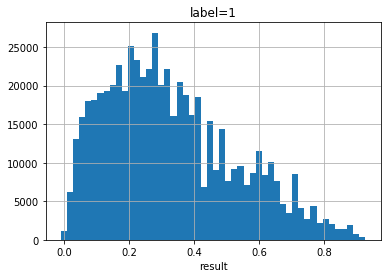

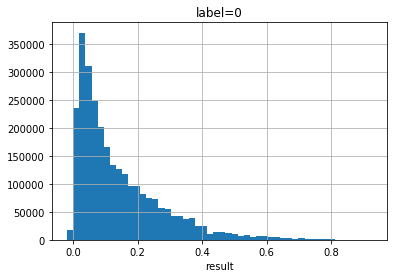

In [38]:
positive=df[df['labels']=='1.0']
negative=df[df['labels']=='0.0']
(positive['result']).hist(bins=50)
plt.xlabel('result')
plt.title('label=1')
plt.show()
(negative['result']).hist(bins=50)
plt.xlabel('result')
plt.title('label=0')
plt.show()

In [15]:
select=df_final[df_final['result']>0.2] # select data according to histogram

select=select.loc[test_ids] # select data to be predict

pred=select['products'].groupby(select.index).sum() # summing products
pred=pred.fillna('None') # replace empties by 'None's

pred.to_csv('regression.csv', header=True) # final file